In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

from tensorflow import keras 
from tensorflow.keras.preprocessing.image import load_img

In [3]:
# data_root_path = "D:/oxford_pets_data"
data_root_path = "./"

In [4]:
img_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/images/*.jpg")])
label_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/annotations/trimaps/[!._]*.png")])

# Validate images match labels in order & count

In [5]:
def get_img_id(img_path):
    return img_path.split("/")[-1].split(".")[0]

In [6]:
assert(all([get_img_id(img_paths[i]) == get_img_id(label_paths[i]) for i in range(len(img_paths))]))

In [7]:
assert(len(img_paths) == len(label_paths))
print(len(img_paths))

7390


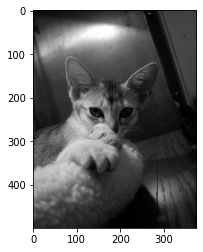

In [8]:
img = cv2.imread(img_paths[1], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

In [9]:
def map2bin(lab, fg_vals, bg_vals, fg=1, bg=0):
    fg_mask = np.isin(lab, fg_vals)
    bg_mask = np.isin(lab, bg_vals)
    lab_c = lab.copy()
    lab_c[fg_mask] = fg
    lab_c[bg_mask] = bg
    return lab_c

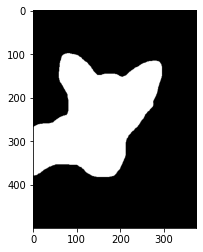

In [10]:
# Trimap:
# 1 -> foreground
# 2 -> background
# 3 -> foreground outline

lab = cv2.imread(label_paths[1])
lab = map2bin(lab, [1, 3], [2])
plt.imshow(lab * 255, cmap="gray")
plt.show()

In [51]:
from tensorflow.keras import layers
class OxfordPetsSequence(keras.utils.Sequence):
    """Helper to iterate over the data"""
    # TODO: edit to turn off augmentations
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size 
        self.img_size = img_size 
        self.input_img_paths = input_img_paths 
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns the batch (input, target) at index `idx`"""
        i = idx * self.batch_size 
        batch_input_img_paths = self.input_img_paths[i : i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i+self.batch_size]
        # load the input images and convert them to grayscale
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.expand_dims(img, 2) # add a third dimension to the array
            x[j] = img 
        # load the target images and condense the number of channels in the segmentation mask
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.expand_dims(img, 2) # add a third dimension to the array
            img = np.where(img==2, 0, 1)
            y[j] = img

        # randomly rotate and reflect the data
        # as we use the same seed for images and targets, the same operation is performed
        rotation_seed = np.random.randint(10000)
        reflection_seed = np.random.randint(10000)
        x = layers.RandomRotation(5, seed=rotation_seed)(x)
        y = layers.RandomRotation(5, seed=rotation_seed)(y)
        x = layers.RandomFlip(seed=reflection_seed)(x)
        y = layers.RandomFlip(seed=reflection_seed)(y)

        return x, y

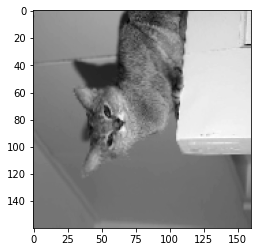

In [55]:
pets = OxfordPetsSequence(32, (160,160), img_paths, label_paths)
X, y = pets[1]
plt.imshow(X[1][:,:,0], cmap='gray')


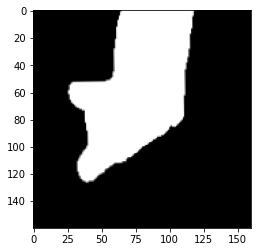

In [56]:
plt.imshow(y[1][:,:,0], cmap='gray')

In [57]:
def get_oxford_pets_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))
    
    ### Downsampling the inputs ###
    
    # compute an initial set of 32 features using convolutional layers 
    # also, downsample the image using strided convolutions
    x = layers.Conv2D(32, 3, strides = 2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    # hidden layers using Xception convolutions
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])
        
        previous_block_activation = x
        
    ### upsampling ###
    
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  
        previous_block_activation = x  
        
    # add a per-pixel classification layer 
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    # define the model 
    model = keras.Model(inputs, outputs)
    
    return model
        

In [58]:
# training parameters
img_size = (160, 160)
num_classes = 2
batch_size = 32

In [62]:
### load the data ###
# shuffle the data
import random
num_val_samples = 1000
random.Random(0).shuffle(img_paths)
random.Random(0).shuffle(label_paths)
# splitting paths for training and validation
train_input_img_paths = img_paths[:-num_val_samples]
train_target_img_paths = label_paths[:-num_val_samples]
val_input_img_paths = img_paths[-num_val_samples:]
val_target_img_paths = label_paths[-num_val_samples:]
# create a data Sequence 
train_gen = OxfordPetsSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [59]:
### create the model ###
keras.backend.clear_session()
model = get_oxford_pets_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [60]:
import tensorflow as tf
tf.device(tf.test.gpu_device_name())

/device:GPU:0


In [63]:
### train the model ###
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation_2classes_augmentations.h5", save_best_only=True)]
num_epochs = 15
model.fit(train_gen, validation_data=val_gen, epochs=num_epochs, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 115s 492ms/step - loss: 0.9890 - val_loss: 7.4305
Epoch 2/15
199/199 [==============================] - 98s 493ms/step - loss: 0.4599 - val_loss: 5.9386
Epoch 3/15
199/199 [==============================] - 98s 492ms/step - loss: 0.3968 - val_loss: 0.4029
Epoch 4/15
199/199 [==============================] - 98s 489ms/step - loss: 0.3663 - val_loss: 0.3871
Epoch 5/15
199/199 [==============================] - 98s 490ms/step - loss: 0.3456 - val_loss: 0.4344
Epoch 6/15
199/199 [==============================] - 97s 489ms/step - loss: 0.3317 - val_loss: 0.3639
Epoch 7/15
199/199 [==============================] - 97s 488ms/step - loss: 0.3188 - val_loss: 0.3644
Epoch 8/15
199/199 [==============================] - 98s 491ms/step - loss: 0.3085 - val_loss: 0.3350
Epoch 9/15
199/199 [==============================] - 98s 491ms/step - loss: 0.3010 - val_loss: 0.3530
Epoch 10/15
199/199 [==============================] - 98s 492ms/step - 

In [67]:
# Generate predictions for all images in the validation set
val_gen = OxfordPetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

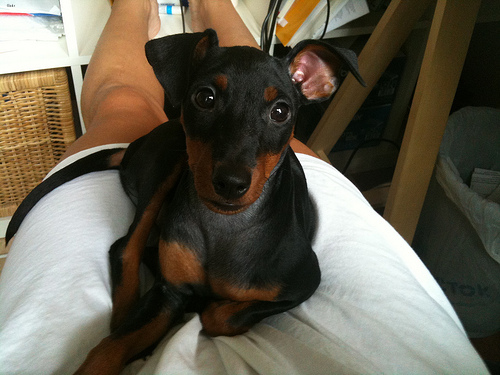

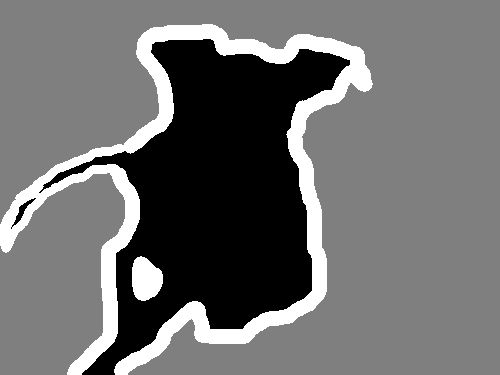

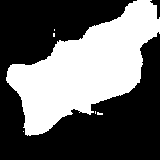

In [71]:
from IPython.display import Image, display
import PIL
from PIL import ImageOps

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 600

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.